In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv','geolocation')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='nanu@999',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/a/OneDrive/Desktop/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import mysql.connector
import numpy as np
import warnings
warnings.filterwarnings('ignore')


db = mysql.connector.connect(host='localhost',
                            username='root',
                            password='nanu@999',
                             database='ecommerce')

cur = db.cursor()

1.List all unique cities where customers are located.

In [22]:
query = """select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['cities'])
df.head()

,cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


2.Count the number of orders placed in 2017.

In [23]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
'total number of orders placed in 2017 are',data[0]

('total number of orders placed in 2017 are', (405909,))

3.Find the total sales per category.

In [25]:
query = """select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Category','sales'])
df


,Category,sales
0,PERFUMERY,2.594502e+08
1,FURNITURE DECORATION,7.322503e+08
2,TELEPHONY,2.492836e+08
3,BED TABLE BATH,8.768275e+08
4,AUTOMOTIVE,4.363747e+08
...,...,...
69,CDS MUSIC DVDS,6.141082e+05
70,LA CUISINE,1.491727e+06
71,FASHION CHILDREN'S CLOTHING,4.022630e+05
72,PC GAMER,1.113308e+06


4.Calculate the percentage of orders that were paid in installments.

In [26]:
query = """select sum(case when payment_installments >=1 then 1
else 0 end)/count(*)*100 from payments"""
cur.execute(query)
data = cur.fetchall()
'percentage of orders that were paid in installments is',data[0][0]

('percentage of orders that were paid in installments is', Decimal('99.9981'))

5.Count the number of customers from each state.

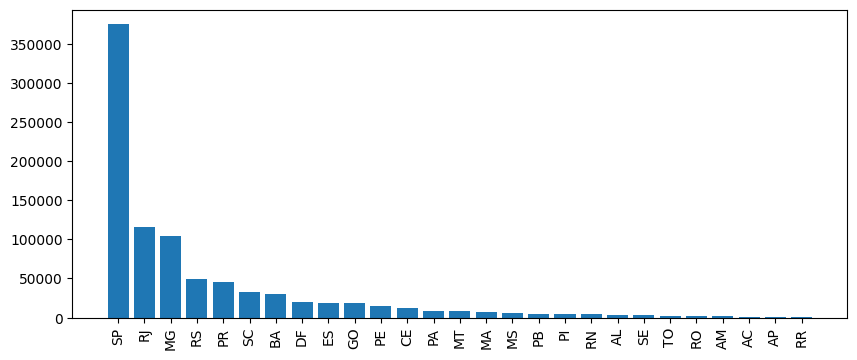

In [27]:
query = """select customer_state,count(customer_id)
from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['state','customer_count'])
df = df.sort_values(by = 'customer_count',ascending= False)
df
plt.figure(figsize=(10,4))
plt.bar(df['state'],df['customer_count'])
plt.xticks(rotation=90)
plt.show()

6. Calculate the number of orders per month in 2018.


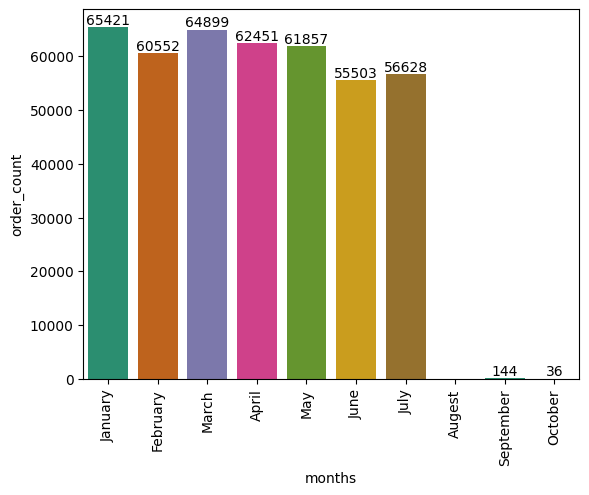

In [44]:
query= """select monthname(order_purchase_timestamp) months,count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months"""
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data,columns=['months','order_count'])
df
o=['January','February','March','April','May','June','July','Augest','September','October']
ax = sns.barplot(x='months',y='order_count',data=df,order=o,palette='Dark2')
plt.xticks(rotation=90)
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

 7. Find the average number of products per order, grouped by customer city.

In [21]:
query = """with  count_per_order as
(select orders.customer_id,orders.order_id,count(order_items.order_id) as order_count 
from ecommerce.orders join order_items
on orders.order_id = order_items.order_id
group by orders.customer_id,orders.order_id) 

select customers.customer_city,round(avg(count_per_order.order_count),2) as average_orders  
from ecommerce.customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['customer_city','average_order'])
df

,customer_city,average_order
0,treze tilias,91.64
1,indaial,80.31
2,sao jose dos campos,81.97
3,sao paulo,83.25
4,porto alegre,84.59
...,...,...
4105,guairaca,144.00
4106,sambaiba,72.00
4107,japaratuba,72.00
4108,tuiuti,72.00


8. Calculate the percentage of total revenue contributed by each product category.

In [19]:
query ="""select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payments.payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['category','sales_percentage'])
df

,category,sales_percentage
0,BED TABLE BATH,684.64
1,HEALTH BEAUTY,662.58
2,COMPUTER ACCESSORIES,633.78
3,FURNITURE DECORATION,571.75
4,WATCHES PRESENT,571.37
...,...,...
69,PC GAMER,0.87
70,HOUSE COMFORT 2,0.68
71,CDS MUSIC DVDS,0.48
72,FASHION CHILDREN'S CLOTHING,0.31


9.Identify the correlation between product price and the number of times a product has been purchased.

In [16]:
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by product_category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['category','order_count','price'])
df
arr1 =df['order_count']
arr2 = df['price']
a = np.corrcoef([arr1,arr2])
print('the correlation between price and and the number of times a product has been purchased',a[0][-1])

the correlation between price and and the number of times a product has been purchased -0.10631514167157562


10. Calculate the total revenue generated by each seller, and rank them by revenue.


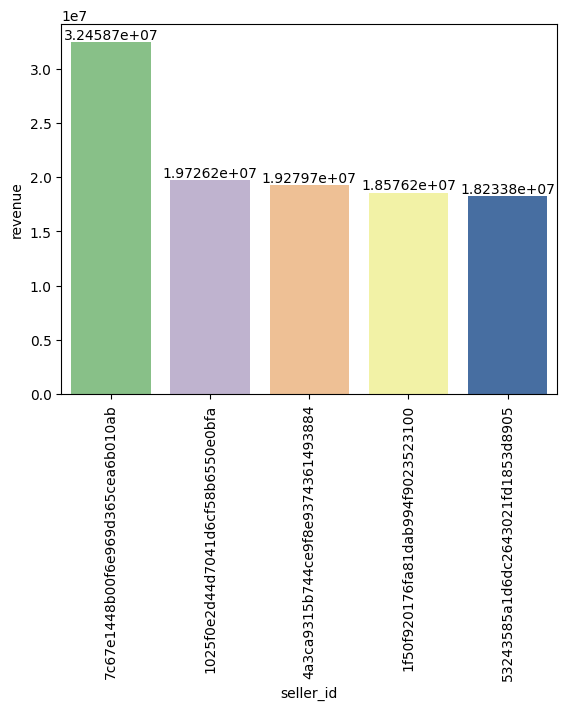

In [45]:
query = """select *,dense_rank() over (order by revenue desc) as rn from
(select order_items.seller_id,sum(payments.payment_value) as revenue
from order_items join  payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['seller_id','revenue','rank'])
df = df.head()


ax = sns.barplot(x='seller_id',y='revenue',data = df,palette='Accent')
for bars in ax.containers:
    ax.bar_label(bars)
plt.xticks(rotation = 90)
plt.show()

11. Calculate the moving average of order values for each customer over their order history.


In [13]:
query="""select customer_id,order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['customer_id','order_purchase_timestamp','payment','mov_avg'])
df

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
7479787,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
7479788,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
7479789,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
7479790,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


12. Calculate the cumulative sales per month for each year.

In [7]:
query ="""select years,months,payments,sum(payments)
over(order by years,months) cumalative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payments
 from ecommerce.orders join payments
 on orders.order_id = payments.order_id
 group by years,months order by years,months) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['month','years','payments','cumalative_sales'])
df

,month,years,payments,cumalative_sales
0,2016,9,18161.28,1.816128e+04
1,2016,10,4254514.56,4.272676e+06
2,2016,12,1412.64,4.274088e+06
3,2017,1,9971138.88,1.424523e+07
4,2017,2,21017376.68,3.526260e+07
5,2017,3,32390179.17,6.765278e+07
6,2017,4,30080738.12,9.773352e+07
7,2017,5,42690155.05,1.404237e+08
8,2017,6,36811899.38,1.772356e+08
9,2017,7,42651570.20,2.198871e+08


13. Calculate the year-over-year growth rate of total sales.

In [42]:
query= """with a as(select year(order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
select years,((payment-lag(payment,1) over (order by years))/
lag(payment,1) over (order by years))*100
previous_year from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['years','yoy % growth'])
df


,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


14. Identify the top 3 customers who spent the most money in each year.


In [4]:
query="""select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value)  payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) 
 order by sum(payments.payment_value)desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['years','customer_id','payments','rank'])
df

,years,customer_id,payments,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,102495.603516,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,100853.279297,2
2,2016,4a06381959b6670756de02e07b83815f,88400.162109,3
3,2017,1617b1357756262bfa56ab541c47bc16,983813.765625,1
4,2017,c6e2731c5b391845f6800c97401a43a9,498910.324219,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,484319.531250,3
6,2018,ec5b2ba62e574342386871631fafd3fc,523791.351562,1
7,2018,f48d464a0baaea338cb25f816991ab1f,498399.117188,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,346279.675781,3


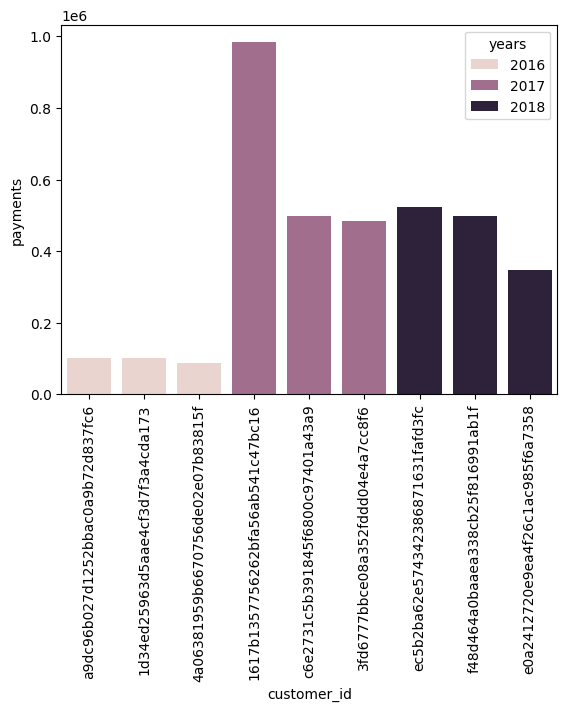

In [5]:
sns.barplot(x='customer_id',y='payments',data = df,hue='years')
plt.xticks(rotation =90)
plt.show()